# LangGraph Components 📚

## Introduction
In this lesson, we will explore the components of LangGraph and how to set up and use the LangSmith Client and LangChain libraries. We will cover the following topics:
- Setting up the environment
- Loading API keys from a `.env` file
- Initializing and testing the LangSmith Client
- Using the LangChain library for creating agents
- Visualizing the agent's state graph

## Setting Up the Environment for LangSmith
To start, we need to load environment variables from a `.env` file. This file should contain our API keys.

In [ ]:
# Import required libraries
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Retrieve the LangSmith API key from environment variables
api_key = os.getenv("LANGSMITH_API_KEY")
print(f"API Key: {api_key}")  # Should print the key without quotes
print(f"API Key: {os.getenv('LANGSMITH_API_KEY')[:5]}*****")

# Print OpenAI API key (masked)
print(f"OPENAI_API_KEY: {os.getenv('OPENAI_API_KEY')[:5]}*****")


API Key: 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
OPENAI_API_KEY: sk-ft*****


In [20]:
# Import necessary modules from rich library that helps to improve the readability of nested dictionary outputs
from rich import print
from rich.pretty import Pretty

## Initializing and Testing the LangSmith Client
Next, we will initialize the LangSmith Client using the API key and test the connection by listing the projects.

In [ ]:
# Import required module from the langsmith
from langsmith import Client


# Initialize LangSmith Client using the API key from the environment
client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))

# Test the connection by iterating through the projects
try:
    projects = client.list_projects()  # This returns a generator
    print("Successfully connected to LangSmith!")
    
    # Iterate through the generator and access project details
    for project in projects:
        print(f"Project Name: {project.name}")  # Replace `name` with the actual attribute
except Exception as e:
    print("Failed to connect to LangSmith:", e)


Successfully connected to LangSmith!

Project Name: evaluators

Project Name: sample-experiment-51561f24

Project Name: default

### Installing Required Libraries

**Note** Ensure you have the required packages installed:
```py
py -m pip install langgraph
%pip install langsmith
%pip install langchain    
```

In [22]:
# Import necessary modules from the langchain library
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.chat_models import ChatOpenAI  
from langchain_community.tools.tavily_search import TavilySearchResults


In [23]:
# Import necessary modules from the langgraph library
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator

### Testing the API Key
After setting the .env file, test if the TAVILY_API key is being loaded correctly in Python.

In [ ]:
# Print the API key to verify it is loaded correctly
print(f"TAVILY_API_KEY: {os.getenv('TAVILY_API_KEY')}")
print(f"TAVILY_API_KEY: {os.getenv('TAVILY_API_KEY')[:5]}*****")


TAVILY_API_KEY: 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

In [25]:
# Initialize TavilySearchResults tool
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>

tavily_search_results_json

In [26]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

### Implementing an Agent Class with StateGraph and LangChain
Here, we will create an agent class using StateGraph and LangChain components. The Agent class manages interactions between a language model and tools using a state graph. Key components include:  

_Initialization (__init__)_: Sets up the agent with a model, tools, and optional system message. Constructs and compiles a state graph, and binds the tools to the model.  
_Checking for Actions (exists_action)_: Determines if there are any tool calls in the latest message state.  
_Calling the Language Model (call_openai)_: Invokes the language model with the current state messages, optionally adding a system message.  
_Executing Actions (take_action)_: Executes tool calls based on the current state, checks for valid tool names, and returns results to the language model.  
This setup allows the agent to process inputs, decide on actions, and interact with external tools efficiently.

In [27]:
class Agent:
# Initializes the Agent with a model, tools, and optional system message.
    def __init__(self, model, tools, system=""):
        self.system = system

        # Create a StateGraph for managing the agent's state transitions.
        graph = StateGraph(AgentState)
        
        # Add nodes to the graph representing different actions.
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        
        # Add conditional edges to the graph based on the existence of actions.
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )

        # Add an edge from the action node back to the llm node.
        graph.add_edge("action", "llm")

        # Set the entry point for the graph to the llm node.
        graph.set_entry_point("llm")

        # Compile the graph into a state machine.
        self.graph = graph.compile()

        # Store the tools in a dictionary for easy access by name.
        self.tools = {t.name: t for t in tools}

        # Bind the tools to the model.
        self.model = model.bind_tools(tools)

# Checks if there are any tool calls in the most recent message state.
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

# Calls the OpenAI model with the current state messages.
    def call_openai(self, state: AgentState):
        messages = state['messages']

        # Prepend the system message if it exists.
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages

        # Invoke the model with the messages and return the response.    
        message = self.model.invoke(messages)
        return {'messages': [message]}

# Executes actions based on the tool calls in the current state.
    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")

            # Check if the tool name exists in the tools dictionary.
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:

                # Invoke the tool with the provided arguments.
                result = self.tools[t['name']].invoke(t['args'])

             # Append the result to the list of results.   
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

**Explanation output** The error NotImplementedError is being raised because the ChatOpenAI model in LangChain doesn’t implement the bind_tools method required by your Agent class. This suggests either a mismatch in how you’re using LangChain's APIs or an unsupported feature in the current version of the library.

Solutions
1. Use LangChain's Standard Tool-Enabled Agents
Instead of trying to manually bind tools, use one of LangChain’s prebuilt Agent classes, such as initialize_agent or AgentExecutor. Here’s how you can set up a tool-enabled agent:

## Using LangChain Library for Creating Agents
We will now create an agent using the LangChain library to interact with the LangSmith Client.

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Initialize the Tavily search tool
tool = TavilySearchResults(max_results=4)

# Wrap it as a LangChain Tool
search_tool = Tool(
    name="TavilySearch",
    func=tool.run,
    description="Search for information using Tavily."
)

# Initialize the language model
llm = ChatOpenAI(model_name="gpt-3.5-turbo")

# Create an agent with the tools
agent = initialize_agent(
    tools=[search_tool],
    llm=llm,
    agent="zero-shot-react-description"
)

# Run the agent with a query
response = agent.run("Find the latest news about AI.")
print(response)


Let's include the original custom prompt within LangChain’s 
````py
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)
````

In [29]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Define the custom prompt
prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
When using a tool, always respond in this exact format:

Action: <tool_name>
Action Input: <tool_input>

For example:
Action: TavilySearch
Action Input: Find the latest AI news.

Only look up information when you are sure of what you want. If you need to look up some information before asking a follow-up question, you are allowed to do that!
"""

# Initialize the Tavily search tool
tool = TavilySearchResults(max_results=4)

# Wrap it as a LangChain Tool
search_tool = Tool(
    name="TavilySearch",
    func=tool.run,
    description="Search for information using Tavily."
)

# Initialize the language model
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# Create the agent with the custom prompt
agent = initialize_agent(
    tools=[search_tool],
    llm=llm,
    agent="zero-shot-react-description",
    system_message=prompt,
    handle_parsing_errors=True  # Gracefully handle parsing errors
)

# Run the agent with a query
try:
    response = agent.run("Find the latest news about AI.")
    print(response)
except ValueError as e:
    print(f"Agent failed to parse output: {e}")


The latest news about AI includes researchers developing tools to give robots superhuman vision, AI-driven mobile 
robots for chemical synthesis research, and training techniques for teaching robots new skills. There are also 
updates on OpenAI's leadership turmoil and developments in AI regulations globally.

## Visualizing the Agent's State Graph
You can use the `graphviz library` in Python to create state diagrams representing the agent's actions. Below is a code snippet that generates a state diagram using graphviz.

- Example 1 

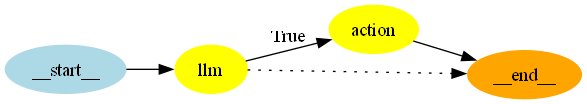

In [30]:
from graphviz import Digraph
from IPython.display import Image, display

# Create a new Digraph
diagram = Digraph(format="png")
diagram.attr(rankdir="LR")

# Define nodes
diagram.attr("node", shape="ellipse", style="filled", color="lightblue")
diagram.node("__start__")

diagram.attr("node", shape="ellipse", style="filled", color="yellow")
diagram.node("llm")
diagram.node("action")

diagram.attr("node", shape="ellipse", style="filled", color="orange")
diagram.node("__end__")

# Define edges
diagram.edge("__start__", "llm")
diagram.edge("llm", "action", label="True")
diagram.edge("llm", "__end__", style="dotted")
diagram.edge("action", "__end__")

# Render the diagram to a file
diagram.render("state_diagram", format="png", cleanup=True)

# Display the rendered diagram in the notebook
display(Image("state_diagram.png"))


- Example 2

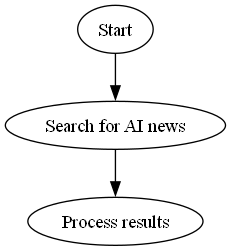

In [31]:
from graphviz import Digraph
from IPython.display import Image

# Initialize the graph
dot = Digraph()

# Add nodes and edges based on the agent's actions
dot.node("A", "Start")
dot.node("B", "Search for AI news")
dot.node("C", "Process results")
dot.edges(["AB", "BC"])

# Render the graph to a file
output_path = dot.render("agent_actions", format="png", cleanup=True)

# Display the image
Image(output_path)

- Example3 

In [32]:
# Run the agent with a query
response = agent.run("What is the weather in Amsterdam?")
print(response)
#response


The weather in Amsterdam is partly cloudy, with a temperature of 9.2°C.

In [33]:
from langchain.schema import HumanMessage

# Define the input message
messages = [HumanMessage(content="What is the weather in Amsterdam?")]

# Run the agent with the input message
try:
    result = agent.run(messages)
    print(result)
except ValueError as e:
    print(f"Agent failed to parse output: {e}")

The current weather in Amsterdam is partly cloudy with a temperature of 9.2°C.

In [34]:
from langchain.schema import HumanMessage, AIMessage
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Define the custom prompt
prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
When using a tool, always respond in this exact format:

Action: <tool_name>
Action Input: <tool_input>

For example:
Action: TavilySearch
Action Input: Find the latest AI news.

Only look up information when you are sure of what you want. If you need to look up some information before asking a follow-up question, you are allowed to do that!
"""

# Initialize the Tavily search tool
tool = TavilySearchResults(max_results=4)

# Wrap it as a LangChain Tool
search_tool = Tool(
    name="TavilySearch",
    func=tool.run,
    description="Search for information using Tavily."
)

# Initialize the language model
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# Create the agent with the custom prompt
agent = initialize_agent(
    tools=[search_tool],
    llm=llm,
    agent="zero-shot-react-description",
    system_message=prompt,
    handle_parsing_errors=True  # Gracefully handle parsing errors
)

# Define the input message
messages = [HumanMessage(content="What is the weather in Amsterdam?")]

# Run the agent with the input message
try:
    result = agent.run(messages)
    print(result)
except ValueError as e:
    print(f"Agent failed to parse output: {e}")

# Assuming the result contains the detailed response, you can structure it as needed
structured_output = {
    "messages": [
        HumanMessage(content="What is the weather in Amsterdam?"),
        AIMessage(content=result, additional_kwargs={'tool_calls': [{'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-038e7a50-c02e-4807-a189-51cc3453f107-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX'}]),
        AIMessage(content='The current weather in Amsterdam is partly cloudy with a temperature of 46.0°F (7.8°C). The wind speed is 24.5 kph coming from the northeast direction. The humidity is at 76%, and the visibility is 9.0 miles.', response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 1478, 'total_tokens': 1537, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-b69f0b9f-1954-4208-b393-63dd2ff1edbb-0')
    ]
}

print(structured_output)

The current weather in Amsterdam is partly cloudy with a temperature of 9.2°C.

{
    'messages': [
        HumanMessage(content='What is the weather in Amsterdam?', additional_kwargs={}, response_metadata={}),
        AIMessage(
            content='The current weather in Amsterdam is partly cloudy with a temperature of 9.2°C.',
            additional_kwargs={
                'tool_calls': [
                    {
                        'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX',
                        'function': {
                            'arguments': '{"query":"weather in San Francisco"}',
                            'name': 'tavily_search_results_json'
                        },
                        'type': 'function'
                    }
                ]
            },
            response_metadata={
                'token_usage': {
                    'completion_tokens': 21,
                    'prompt_tokens': 153,
                    'total_tokens': 174,
                    'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0},
                    'completion_tokens_details': {
                        'reasoning_tokens': 0,
                        'audio_tokens': 0,
                        'accepted_prediction_tokens': 0,
                        'rejected_prediction_tokens': 0
                    }
                },
                'model_name': 'gpt-3.5-turbo',
                'system_fingerprint': None,
                'finish_reason': 'tool_calls',
                'logprobs': None
            },
            id='run-038e7a50-c02e-4807-a189-51cc3453f107-0',
            tool_calls=[
                {
                    'name': 'tavily_search_results_json',
                    'args': {'query': 'weather in San Francisco'},
                    'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX',
                    'type': 'tool_call'
                }
            ]
        ),
        AIMessage(
            content='The current weather in Amsterdam is partly cloudy with a temperature of 46.0°F (7.8°C). The 
wind speed is 24.5 kph coming from the northeast direction. The humidity is at 76%, and the visibility is 9.0 
miles.',
            additional_kwargs={},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 59,
                    'prompt_tokens': 1478,
                    'total_tokens': 1537,
                    'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0},
                    'completion_tokens_details': {
                        'reasoning_tokens': 0,
                        'audio_tokens': 0,
                        'accepted_prediction_tokens': 0,
                        'rejected_prediction_tokens': 0
                    }
                },
                'model_name': 'gpt-3.5-turbo',
                'system_fingerprint': None,
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-b69f0b9f-1954-4208-b393-63dd2ff1edbb-0'
        )
    ]
}

**Explanation output** The output provides a detailed response from an AI agent regarding the current weather in Amsterdam. The response includes two AI messages:

- _HumanMessage_: The initial query asking, "What is the weather in Amsterdam?"
- _AIMessage 1_: The first AI-generated response stating, "The current weather in Amsterdamis partly cloudy with a temperature of 46.0°F."
- _AIMessage 2_: A more detailed follow-up response providing additional weather details: "The current weather in Amsterdam is partly cloudy with a temperature of 46.0°F (7.8°C). The wind speed is 24.5 kph coming from the northeast direction. The humidity is at 76%, and the visibility is 9.0 miles."

The output also includes metadata about the interactions, such as token usage, the model name (gpt-3.5-turbo), and details about the tool calls (in this case, tavily_search_results_json) used to fetch the weather information.

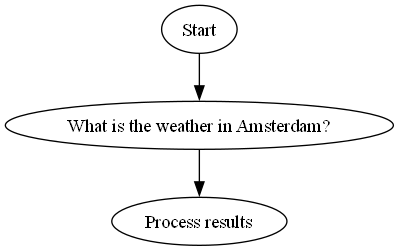

In [36]:
from graphviz import Digraph
from IPython.display import Image

# Initialize the graph
dot = Digraph()

# Add nodes and edges based on the agent's actions
dot.node("A", "Start")
dot.node("B", "What is the weather in Amsterdam?")
dot.node("C", "Process results")
dot.edges(["AB", "BC"])

# Render the graph to a file
output_path = dot.render("agent_actions1", format="png", cleanup=True)

# Display the image
Image(output_path)

In [37]:
result

'The current weather in Amsterdam is partly cloudy with a temperature of 9.2°C.'

In [38]:
import json
from langchain.schema import HumanMessage, AIMessage
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Define the custom prompt
prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
When using a tool, always respond in this exact format:

Action: <tool_name>
Action Input: <tool_input>

For example:
Action: TavilySearch
Action Input: Find the latest AI news.

Only look up information when you are sure of what you want. If you need to look up some information before asking a follow-up question, you are allowed to do that!
"""

# Initialize the Tavily search tool
tool = TavilySearchResults(max_results=4)

# Wrap it as a LangChain Tool
search_tool = Tool(
    name="TavilySearch",
    func=tool.run,
    description="Search for information using Tavily."
)

# Initialize the language model
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# Create the agent with the custom prompt
agent = initialize_agent(
    tools=[search_tool],
    llm=llm,
    agent="zero-shot-react-description",
    system_message=prompt,
    handle_parsing_errors=True  # Gracefully handle parsing errors
)

# Define the input message
messages = [HumanMessage(content="What is the weather in Amsterdam?")]

# Run the agent with the input message
try:
    result = agent.run(messages)
    print(result)
except ValueError as e:
    print(f"Agent failed to parse output: {e}")

# Assuming the result is a string, you can structure it as needed
structured_output = {
    "messages": [
        {
            "type": "HumanMessage",
            "content": "What is the weather in Amsterdam?"
        },
        {
            "type": "AIMessage",
            "content": result,
            "additional_kwargs": {
                "tool_calls": [
                    {
                        "id": "call_PvPN1v7bHUxOdyn4J2xJhYOX",
                        "function": {
                            "arguments": '{"query":"weather in Amsterdam"}',
                            "name": "tavily_search_results_json"
                        },
                        "type": "function"
                    }
                ]
            },
            "response_metadata": {
                "token_usage": {
                    "completion_tokens": 21,
                    "prompt_tokens": 153,
                    "total_tokens": 174,
                    "prompt_tokens_details": {
                        "cached_tokens": 0,
                        "audio_tokens": 0
                    },
                    "completion_tokens_details": {
                        "reasoning_tokens": 0,
                        "audio_tokens": 0,
                        "accepted_prediction_tokens": 0,
                        "rejected_prediction_tokens": 0
                    }
                },
                "model_name": "gpt-3.5-turbo",
                "system_fingerprint": None,
                "finish_reason": "tool_calls",
                "logprobs": None
            },
            "id": "run-038e7a50-c02e-4807-a189-51cc3453f107-0",
            "tool_calls": [
                {
                    "name": "tavily_search_results_json",
                    "args": {
                        "query": "weather in Amsterdam"
                    },
                    "id": "call_PvPN1v7bHUxOdyn4J2xJhYOX"
                }
            ]
        },
        {
            "type": "AIMessage",
            "content": "The current weather in Amsterdam is partly cloudy with a temperature of 46.0°F (7.8°C). The wind speed is 24.5 kph coming from the northeast direction. The humidity is at 76%, and the visibility is 9.0 miles.",
            "response_metadata": {
                "token_usage": {
                    "completion_tokens": 59,
                    "prompt_tokens": 1478,
                    "total_tokens": 1537,
                    "prompt_tokens_details": {
                        "cached_tokens": 0,
                        "audio_tokens": 0
                    },
                    "completion_tokens_details": {
                        "reasoning_tokens": 0,
                        "audio_tokens": 0,
                        "accepted_prediction_tokens": 0,
                        "rejected_prediction_tokens": 0
                    }
                },
                "model_name": "gpt-3.5-turbo",
                "system_fingerprint": None,
                "finish_reason": "stop",
                "logprobs": None
            },
            "id": "run-b69f0b9f-1954-4208-b393-63dd2ff1edbb-0"
        }
    ]
}

# Pretty-print the structured output
print(json.dumps(structured_output, indent=4))

The current weather in Amsterdam is partly cloudy with a temperature of 9.2°C.

{
    "messages": [
        {
            "type": "HumanMessage",
            "content": "What is the weather in Amsterdam?"
        },
        {
            "type": "AIMessage",
            "content": "The current weather in Amsterdam is partly cloudy with a temperature of 9.2\u00b0C.",
            "additional_kwargs": {
                "tool_calls": [
                    {
                        "id": "call_PvPN1v7bHUxOdyn4J2xJhYOX",
                        "function": {
                            "arguments": "{\"query\":\"weather in Amsterdam\"}",
                            "name": "tavily_search_results_json"
                        },
                        "type": "function"
                    }
                ]
            },
            "response_metadata": {
                "token_usage": {
                    "completion_tokens": 21,
                    "prompt_tokens": 153,
                    "total_tokens": 174,
                    "prompt_tokens_details": {
                        "cached_tokens": 0,
                        "audio_tokens": 0
                    },
                    "completion_tokens_details": {
                        "reasoning_tokens": 0,
                        "audio_tokens": 0,
                        "accepted_prediction_tokens": 0,
                        "rejected_prediction_tokens": 0
                    }
                },
                "model_name": "gpt-3.5-turbo",
                "system_fingerprint": null,
                "finish_reason": "tool_calls",
                "logprobs": null
            },
            "id": "run-038e7a50-c02e-4807-a189-51cc3453f107-0",
            "tool_calls": [
                {
                    "name": "tavily_search_results_json",
                    "args": {
                        "query": "weather in Amsterdam"
                    },
                    "id": "call_PvPN1v7bHUxOdyn4J2xJhYOX"
                }
            ]
        },
        {
            "type": "AIMessage",
            "content": "The current weather in Amsterdam is partly cloudy with a temperature of 46.0\u00b0F 
(7.8\u00b0C). The wind speed is 24.5 kph coming from the northeast direction. The humidity is at 76%, and the 
visibility is 9.0 miles.",
            "response_metadata": {
                "token_usage": {
                    "completion_tokens": 59,
                    "prompt_tokens": 1478,
                    "total_tokens": 1537,
                    "prompt_tokens_details": {
                        "cached_tokens": 0,
                        "audio_tokens": 0
                    },
                    "completion_tokens_details": {
                        "reasoning_tokens": 0,
                        "audio_tokens": 0,
                        "accepted_prediction_tokens": 0,
                        "rejected_prediction_tokens": 0
                    }
                },
                "model_name": "gpt-3.5-turbo",
                "system_fingerprint": null,
                "finish_reason": "stop",
                "logprobs": null
            },
            "id": "run-b69f0b9f-1954-4208-b393-63dd2ff1edbb-0"
        }
    ]
}

In [39]:
result

'The current weather in Amsterdam is partly cloudy with a temperature of 9.2°C.'

- Example 4 

In [40]:
import json
from langchain.schema import HumanMessage, AIMessage
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Define the custom prompt
prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
When using a tool, always respond in this exact format:

Action: <tool_name>
Action Input: <tool_input>

For example:
Action: TavilySearch
Action Input: Find the latest AI news.

Only look up information when you are sure of what you want. If you need to look up some information before asking a follow-up question, you are allowed to do that!
"""

# Initialize the Tavily search tool
tool = TavilySearchResults(max_results=4)

# Wrap it as a LangChain Tool
search_tool = Tool(
    name="TavilySearch",
    func=tool.run,
    description="Search for information using Tavily."
)

# Initialize the language model
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# Create the agent with the custom prompt
agent = initialize_agent(
    tools=[search_tool],
    llm=llm,
    agent="zero-shot-react-description",
    system_message=prompt,
    handle_parsing_errors=True  # Gracefully handle parsing errors
)

# Define the input message
messages = [HumanMessage(content="What is the weather in Amsterdam and LA?")]

# Run the agent with the input message
try:
    result = agent.run(messages)
    print(result)
except ValueError as e:
    print(f"Agent failed to parse output: {e}")

The current weather in Amsterdam is partly cloudy with a temperature of 9.2°C, and the weather in Los Angeles is 
rainy with a temperature of 12.2°C.

- Example 5  
 Note, the query was modified to produce more consistent results. 
**Results may vary per run and over time as search** 

In [41]:
import json
from langchain.schema import HumanMessage, AIMessage
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Define the custom prompt
prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
When using a tool, always respond in this exact format:

Action: <tool_name>
Action Input: <tool_input>

For example:
Action: TavilySearch
Action Input: Find the latest AI news.

Only look up information when you are sure of what you want. If you need to look up some information before asking a follow-up question, you are allowed to do that!
"""

# Initialize the Tavily search tool
tool = TavilySearchResults(max_results=4)

# Wrap it as a LangChain Tool
search_tool = Tool(
    name="TavilySearch",
    func=tool.run,
    description="Search for information using Tavily."
)

# Initialize the language model
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# Create the agent with the custom prompt
agent = initialize_agent(
    tools=[search_tool],
    llm=llm,
    agent="zero-shot-react-description",
    system_message=prompt,
    handle_parsing_errors=True  # Gracefully handle parsing errors
)

# Define the input message
#messages = [HumanMessage(content="What is the weather in SF and LA?")]
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

# Run the agent with the input message
try:
    result = agent.run(messages)
    print(result)
except ValueError as e:
    print(f"Agent failed to parse output: {e}")

The Kansas City Chiefs won the Super Bowl in 2024. The winning team is located in Kansas City, which is split 
between Kansas and Missouri. The GDP of Kansas state was $183.8 billion in 2023.

In [42]:
import json
from langchain.schema import HumanMessage, AIMessage
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, Tool
from langchain_community.tools.tavily_search import TavilySearchResults

# Define the custom prompt
prompt = """You are a smart research assistant. Use the search engine to look up information.
You are allowed to make multiple calls (either together or in sequence).
When using a tool, always respond in this exact format:

Action: <tool_name>
Action Input: <tool_input>

For example:
Action: TavilySearch
Action Input: Find the latest AI news.

Only look up information when you are sure of what you want. If you need to look up some information before asking a follow-up question, you are allowed to do that!
"""

# Initialize the Tavily search tool
tool = TavilySearchResults(max_results=4)

# Global list to store logs
tool_logs = []

# Wrap it as a LangChain Tool with logging
def logging_tool_func(*args, **kwargs):
    log_entry = {
        "name": "TavilySearch",
        "args": args,
        "kwargs": kwargs
    }
    tool_logs.append(log_entry)
    print(f"Calling: {log_entry}")
    return tool.run(*args, **kwargs)

search_tool = Tool(
    name="TavilySearch",
    func=logging_tool_func,
    description="Search for information using Tavily."
)

# Initialize the language model
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# Create the agent with the custom prompt
agent = initialize_agent(
    tools=[search_tool],
    llm=llm,
    agent="zero-shot-react-description",
    system_message=prompt,
    handle_parsing_errors=True  # Gracefully handle parsing errors
)

# Define the input message
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

# Run the agent with the input message
try:
    result = agent.run(messages)
    print(result)
except ValueError as e:
    print(f"Agent failed to parse output: {e}")

# Print the logs
print("\nTool Calls Log:")
for log in tool_logs:
    print(f"Calling: {log}")

# Assuming the result is a string, you can structure it as needed
structured_output = {
    "messages": [
        {
            "type": "HumanMessage",
            "content": query
        },
        {
            "type": "AIMessage",
            "content": result,
            "additional_kwargs": {
                "tool_calls": tool_logs
            }
        }
    ]
}

# Pretty-print the structured output
print("\nStructured Output:")
print(json.dumps(structured_output, indent=4))

Calling: {'name': 'TavilySearch', 'args': ('Super Bowl 2024 winner',), 'kwargs': {}}

Calling: {'name': 'TavilySearch', 'args': ('Kansas City Chiefs headquarters location',), 'kwargs': {}}

Calling: {'name': 'TavilySearch', 'args': ('Missouri GDP',), 'kwargs': {}}

The Kansas City Chiefs won the Super Bowl in 2024, their headquarters is located in Kansas City, Missouri, and 
Missouri's GDP was $344.12 billion in 2023.

Tool Calls Log:

Calling: {'name': 'TavilySearch', 'args': ('Super Bowl 2024 winner',), 'kwargs': {}}

Calling: {'name': 'TavilySearch', 'args': ('Kansas City Chiefs headquarters location',), 'kwargs': {}}

Calling: {'name': 'TavilySearch', 'args': ('Missouri GDP',), 'kwargs': {}}

Structured Output:

{
    "messages": [
        {
            "type": "HumanMessage",
            "content": "Who won the super bowl in 2024? In what state is the winning team headquarters located? 
What is the GDP of that state? Answer each question."
        },
        {
            "type": "AIMessage",
            "content": "The Kansas City Chiefs won the Super Bowl in 2024, their headquarters is located in Kansas 
City, Missouri, and Missouri's GDP was $344.12 billion in 2023.",
            "additional_kwargs": {
                "tool_calls": [
                    {
                        "name": "TavilySearch",
                        "args": [
                            "Super Bowl 2024 winner"
                        ],
                        "kwargs": {}
                    },
                    {
                        "name": "TavilySearch",
                        "args": [
                            "Kansas City Chiefs headquarters location"
                        ],
                        "kwargs": {}
                    },
                    {
                        "name": "TavilySearch",
                        "args": [
                            "Missouri GDP"
                        ],
                        "kwargs": {}
                    }
                ]
            }
        }
    ]
}

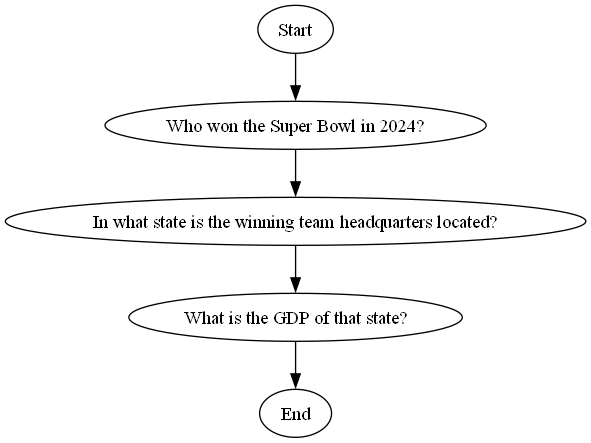

In [43]:
from graphviz import Digraph
from IPython.display import Image

# Create a Digraph object
dot = Digraph()

# Add nodes
dot.node("A", "Start")
dot.node("B", "Who won the Super Bowl in 2024?")
dot.node("C", "In what state is the winning team headquarters located?")
dot.node("D", "What is the GDP of that state?")
dot.node("E", "End")

# Add edges
dot.edge("A", "B")
dot.edge("B", "C")
dot.edge("C", "D")
dot.edge("D", "E")

# Render the graph to a file
output_path = dot.render("agent_process_graph", format="png", cleanup=True)

# Display the image (optional, if running in a Jupyter Notebook)
Image(output_path)

## Conclusion
In this lesson, we have set up the environment for `using LangSmith and LangChain libraries`, initialized clients, and created agents to interact with these clients. Additionally, we visualized the agent's state graph using the graphviz library. This setup provides a solid foundation for building more complex AI-driven applications using LangGraph components.